# Experiments by rotating the filters of the convolution layer: 90/45 degrees. 

# Global variables and libraries

In [1]:
# debug flag to test if the implementation is correct
debug = 1
from IPython.core.debugger import set_trace


In [2]:
import keras

/home/kriti/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.layers.convolutional import Conv2D
from keras import backend as K
import tensorflow as tf


permutation = [[1, 0], [0, 0], [0, 1], [2, 0], [1, 1], [0, 2], [2, 1], [2, 2], [1, 2]]


## Training

In [4]:
# MNIST dataset
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K

batch_size = 128
nb_classes = 10

DIM = 60
mnist_cluttered = "datasets/mnist_cluttered_60x60_6distortions.npz"

# Preparing data
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
print("X_train sample:", X_train[0].shape)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))
#one hot
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))

print("output shape:", y_train.shape)
input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (DIM, DIM, 1)
print("Input shape:",input_shape)

('X_train sample:', (3600,))
Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
('output shape:', (50000, 10))
('Input shape:', (60, 60, 1))


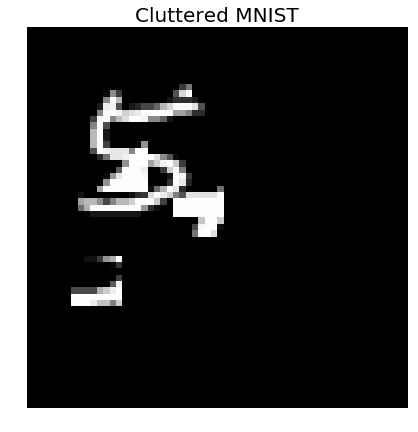

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [6]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras import layers 

## Test the rotation function implementation

In [7]:
""" Sanity check shift_rotate implementation
"""

if(debug):
    import numpy as np
    import tensorflow as tf


    w = np.array(
        [
            [
                [
                    [1, 2, 3],
                    [4, 5, 6],
                    [7, 8, 9]
                ],
                [
                    [11, 22, 33],
                    [44, 55, 66],
                    [77, 88, 99]
                ],
                [
                    [111, 222, 333],
                    [444, 555, 666],
                    [777, 888, 999]
                ]
            ],
            [
                [
                    [1, 2, 3],
                    [4, 5, 6],
                    [7, 8, 9]
                ],
                [
                    [11, 22, 33],
                    [44, 55, 66],
                    [77, 88, 99]
                ],
                [
                    [111, 222, 333],
                    [444, 555, 666],
                    [777, 888, 999]
                ]
            ]
        ]
    )

    w = np.moveaxis(w, (2, 3), (0, 1))

    sess = tf.InteractiveSession()
    # shape: (row, col, inp_nb, out_nb) -> (3, 3, 2, 3)
    w = tf.constant(w)

    w1 = shift_rotate(w, 4)
    print w1.eval()

NameError: name 'shift_rotate' is not defined

## Create Model

In [43]:
def get_model(convs):
    if convs is None:
        convs = [conv_old, conv_old, conv_old, conv_old]
    model = Sequential()

    # model.add(SpatialTransformer(localization_net=locnet,
    #                              output_size=(30,30), input_shape=input_shape))
    model.add(convs[0](32, (3, 3), padding='same', input_shape=input_shape, use_bias=False, activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(convs[0](32, (3, 3), padding='same', use_bias=False, activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(convs[0](32, (3, 3), padding='same', use_bias=False, activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(convs[1](32, (3, 3), use_bias=False, activation='relu'))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

## Functions to rotate the filters and new convolution layer definitions

In [44]:
# shift times according to the parameter shift
def shift_rotate(w, shift=1):
    shape = w.get_shape()
    for i in range(shift):
        #tf.gather_nd gathers the values according to the indices specified in permutation.
        w = tf.reshape(tf.gather_nd(w, permutation), shape)
    return w

#new convolution class which does convolution using 4 rotations
class Convolution2D_4(Conv2D):
    def call(self, x, mask=None):
        w = self.weights[0]
        w_rot = [w]
        # shifts of 90 degrees everytime
        for i in range(3):
            w = shift_rotate(w, shift=2)
            w_rot.append(w)
        
        # convolves all the 4 filters on the input image.
        outputs = tf.stack([K.conv2d(x, w_i, strides=self.strides,
                                     padding=self.padding,
                                     data_format=self.data_format,
#                                      filters=self.weights[0].get_shape
                                    ) for w_i in w_rot])

        output = K.max(outputs, 0)

        if self.use_bias:
            if self.data_format == 'channels_first':
                output += K.reshape(self.use_bias, (1, self.filters, 1, 1))
            elif self.data_format == 'channels_last':
                output += K.reshape(self.use_bias, (1, 1, 1, self.filters))
            else:
                raise ValueError('Invalid dim_ordering:', self.data_format)
        output = self.activation(output)
        return output


class Convolution2D_8(Conv2D):
    def call(self, x, mask=None):
        w = self.weights[0]
        
        w_rot = [w]
        for i in range(7):
            w = shift_rotate(w)
            w_rot.append(w)

        outputs = tf.stack([K.conv2d(x, w_i, strides = self.strides,
                                     padding=self.padding,
                                     data_format=self.data_format,
#                                      filters=self.weights[0].get_shape
                                    ) for w_i in w_rot])
#         set_trace()
        output = K.max(outputs, 0)
        
        if self.use_bias:
            if self.data_format == 'channels_first':
                output += K.reshape(self.use_bias, (1, self.filters, 1, 1))
            elif self.data_format == 'channels_last':
                output += K.reshape(self.use_bias, (1, 1, 1, self.filters))
            else:
                raise ValueError('Invalid dim_ordering:', self.data_format)
        

        output = self.activation(output)
        return output

 ## Training the model

In [45]:
def train(run_name, model, nb_epochs, X_train, y_train, X_valid, y_valid):
    maxVAcc = maxTAcc = maxVScore = maxTScore = epoch = 0
    for e in range(nb_epochs):
        print('-'*40)
#         progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            print(loss)
#             progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev, accv = model.evaluate(X_valid, y_valid, verbose=1)
        scoret, acct = model.evaluate(X_test, y_test, verbose=1)
        if(maxTAcc > acct):
            maxTAcc = acct
            maxVacc = accv
            maxVScore = scorev
            maxTScore = scoret
            epoch = e
        if(e%1==0):
            print('Epoch: {0} | Valid Score: {1}| Test Score: {2}| Valid Acc: {3} | Test Acc: {4}'.format(e, scorev, scoret, accv, acct))
    return maxVAcc, maxTAcc, maxVScore, maxTScore, epoch

In [49]:
conv_8 = Convolution2D_8
conv_old = Conv2D
conv_4 = Convolution2D_4

if __name__ == '__main__':
    # Cleanup old weight dir.
    import os, shutil
    shutil.rmtree('weights', ignore_errors=True)
    os.makedirs('weights')

    names = ['8_rot_4', '8_rot_3', '8_rot_2', '8_rot_1', '4_rot_4', '4_rot_3', '4_rot_2', '4_rot_1', 'baseline']
    convs = [
        [conv_4, conv_old, conv_old, conv_4], 
        [conv_8, conv_8, conv_8, conv_8],
        [conv_old, conv_8, conv_8, conv_8],
        [conv_old, conv_old, conv_8, conv_8],
        [conv_old, conv_old, conv_old, conv_8],
        [conv_4, conv_4, conv_4, conv_4],
        [conv_old, conv_4, conv_4, conv_4],
        [conv_old, conv_old, conv_4, conv_4],
        [conv_old, conv_old, conv_old, conv_4], 
        None
        
    ]

nb_epochs = 110 # you probably want to go longer than this
batch_size = 256

for i in range(len(names)):
    print(names[i])
    model = get_model(convs[i])
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    maxVAcc, maxTAcc, maxVScore, maxTScore, epoch = train(names[i], model, nb_epochs, X_train, y_train, X_valid, y_valid)
    f = open('results.txt','a') 
    f.write("Results for:", names[i])
    f.write('\n')
    f.write('maxVAcc: {0}, maxTAcc: {1}, maxVScore: {2}, maxTScore: {3}, epoch: {4}'.format( maxVAcc, maxTAcc, maxVScore, maxTScore, epoch ))
    f.write("\n\n")
    f.close()
    print('maxVAcc: {0}, maxTAcc: {1}, maxVScore: {2}, maxTScore: {3}, epoch: {4}'.format( maxVAcc, maxTAcc, maxVScore, maxTScore, epoch ))


8_rot_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution2d_4_1 (Convoluti (None, 60, 60, 32)        288       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
convolution2d_4_2 (Convoluti (None, 30, 30, 32)        9216      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
convolution2d_4_3 (Convoluti (None, 15, 15, 32)        9216      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 5, 5, 32)          9216      
__

KeyboardInterrupt: 

# Plots

In [8]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage

from keras.layers import Convolution2D as conv_old


def get_probs_matched(imgs, model, idx):
    probs = model.predict_proba(imgs, verbose=0)
    preds = probs.argmax(axis=-1)
    probs = probs[:, y_test[idx][0]]
    matched = (len(np.where(preds == y_test[idx][0])[0]) * 100.0) / len(imgs)
    return probs, matched


def compare(test_id, angles, models):
    img = X_test[test_id]
    imgs = np.array([ndimage.rotate(img, rot, reshape=False) for rot in angles])

    all_probs = []
    all_matched = []
    for model in models:
        probs, matched = get_probs_matched(imgs, model, test_id)
        all_probs.append(probs)
        all_matched.append(matched)

    return all_probs, all_matched


def plot_multi(names, models, angles, runs=1000):
    indices = np.random.permutation(len(X_test))[:runs]

    matched_all = []
    for i, idx in enumerate(indices):
        print("Processing {}/{}".format(i, len(indices)))
        probs, matched = compare(idx, angles, models)
        matched_all.append(matched)

    matched_all = np.array(matched_all)
    order = np.argsort(np.mean(matched_all, axis=0))
    df = pd.DataFrame.from_items([(names[i], matched_all[:, i]) for i in order])
    sb.boxplot(data=df)
    plt.show()


def plot_single(names, models, angles, test_id):
    all_probs, all_matched = compare(test_id, angles, models)
    legends = []

    order = np.argsort(all_matched)
    for i in order:
        plt.plot(angles, all_probs[i])
        legends.append('{} {:.2f}%'.format(names[i], all_matched[i]))

    plt.ylabel('Prediction probability of correct class')
    plt.legend(legends, loc=9, bbox_to_anchor=(0.5, -0.05), ncol=len(names))
    plt.show()


if __name__ == '__main__':
    names = ['baseline', '8_rot_4', '8_rot_3', '8_rot_2', '8_rot_1', '4_rot_4', '4_rot_3', '4_rot_2', '4_rot_1']
    convs = [
        None,
        [conv_8, conv_8, conv_8, conv_8],
        [conv_old, conv_8, conv_8, conv_8],
        [conv_old, conv_old, conv_8, conv_8],
        [conv_old, conv_old, conv_old, conv_8],
        [conv_4, conv_4, conv_4, conv_4],
        [conv_old, conv_4, conv_4, conv_4],
        [conv_old, conv_old, conv_4, conv_4],
        [conv_old, conv_old, conv_old, conv_4],
    ]

    models = []
    indices = range(len(names))
    for i in indices:
        model = get_model(convs[i])
        model.load_weights('./weights/{}.hdf5'.format(names[i]))
        models.append(model)

    angles = np.arange(0, 360, 1)
    # plot_single([names[i] for i in indices], models, angles=angles, test_id=5)
    plot_multi(names, models, angles=angles, runs=1000)

ImportError: No module named train